<a href="https://colab.research.google.com/github/JaeminKIM-Irene/FC_AI_ML_Project/blob/main/irenekim/ML_Project_LightGBM_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 설치에 필요한 라이브러리들이 있다면 모두 적어둡니다. anaconda에 기본적으로 설치되지 않은 라이브러리들을 적어두세요.
!pip install lightgbm optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

import optuna

from sklearn.model_selection import StratifiedKFold
from functools import partial

from sklearn.metrics import roc_auc_score

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read data
result_list = []
base_url = '/content/drive/MyDrive/Colab Notebooks/data/playground-series-s3e23/'
train = pd.read_csv(base_url+'train.csv', index_col='id')
test = pd.read_csv(base_url+'test.csv', index_col='id')
submission = pd.read_csv(base_url+'sample_submission.csv', index_col='id')

with pd.option_context('display.min_rows', 6) :
  display(train)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,5893.69,...,20,0,4,0,10.0,8.0,51.0,28.0,1.0,False
101761,10.0,2.0,1.0,2.0,43.0,191.76,0.15,6.46,29.53,1534.04,...,7,0,1,0,11.0,14.0,24.0,19.0,3.0,False
101762,136.0,18.0,18.0,1.0,296.0,1704.57,0.02,44.82,44.08,77011.02,...,102,1,11,0,22.0,31.0,162.0,135.0,35.0,False


In [ ]:
X = train.drop(columns=['defects'])
y = train.defects

In [ ]:
# PCA Flag
feature_reducing = True

In [ ]:
# PCA
if feature_reducing :
  from sklearn.decomposition import PCA

  pca = PCA(n_components=0.95,
            whiten=True,
            random_state=61)
  pca.fit(X)
  pca_df = pd.DataFrame(data=pca.transform(X))
  display(pca_df)

,0
0,-0.080883
1,-0.104576
2,-0.100283
3,-0.107008
4,-0.107576
...,...
101758,-0.105233
101759,-0.050322
101760,-0.078545
101761,-0.101438


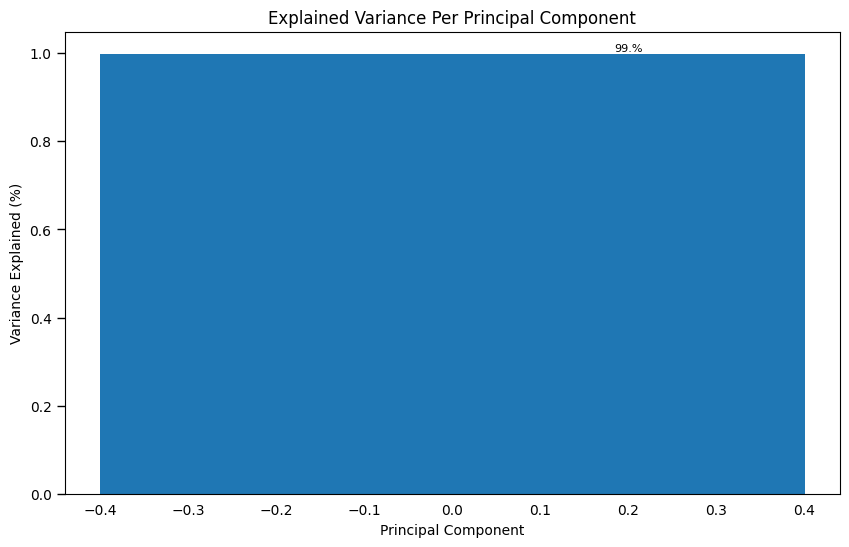

In [ ]:
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_

    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(round(vals[i]*100,1))[:3])), (ind[i]+0.2, vals[i]),
                    va="bottom",
                    ha="center",
                    fontsize=8)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=1, length=6)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
scree_plot(pca)

In [ ]:
# data split for baseline model
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=61)

In [ ]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(96674, 1) (96674,) (5089, 1) (5089,)


## Baseline Model

In [ ]:
# data split for baseline model
from sklearn.model_selection import train_test_split

X = train.drop(columns=['defects'])
y = train.defects

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=61)

In [ ]:
model = LGBMClassifier()

model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 21922, number of negative: 74752
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 96674, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226762 -> initscore=-1.226685
[LightGBM] [Info] Start training from score -1.226685


LGBMClassifier()

In [ ]:
print('======Prediction======')
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

train_score = roc_auc_score(y_train, pred_train)
val_score = roc_auc_score(y_val, pred_val)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % val_score)

======Prediction======
Train Score : 0.6488
Test Score : 0.6315


In [ ]:
from sklearn.decomposition import PCA

model = Pipeline([('scale', StandardScaler()), ('reduce_dims', PCA(n_components=0.90, random_state=61)), ('clf', LGBMClassifier())])
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

train_score = roc_auc_score(y_train, pred_train)
val_score = roc_auc_score(y_val, pred_val)

print("Train Score : %.4f" % train_score)
print("Test Score : %.4f" % val_score)

[LightGBM] [Info] Number of positive: 21922, number of negative: 74752
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 96674, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226762 -> initscore=-1.226685
[LightGBM] [Info] Start training from score -1.226685
Train Score : 0.6730
Test Score : 0.6581


## Optuna

In [ ]:
def optimizer(trial, X, y, K) :
  num_leaves = trial.suggest_categorical('num_leaves', [64, 128, 256, 512])
  #num_leaves=64
  max_depth = trial.suggest_int('max_depth', 10, 25)
  learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3)
  #learning_rate=0.031916736552884926
  min_child_samples = trial.suggest_int('min_child_samples', 1, 100)
  colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 0.8)

  model = Pipeline([
      ('scale', StandardScaler()),
      ('reduce_dims', PCA(n_components=0.90, random_state=61)),
      ('clf', LGBMClassifier(num_leaves=num_leaves,
                            max_depth=max_depth,
                            learning_rate=learning_rate,
                            min_child_samples=min_child_samples,
                            colsample_bytree=colsample_bytree,
                            is_unbalance=True,
                            random_state=61))])

  folds = StratifiedKFold(shuffle=True, random_state=61)
  oof = np.full(len(train), np.nan)
  auc_list = []

  for train_idx, val_idx in folds.split(X, y) :
    X_train = X.iloc[train_idx, :]
    y_train = y.iloc[train_idx]

    X_val = X.iloc[val_idx, :]
    y_val = y.iloc[val_idx]

    model.fit(X_train, y_train)

    try :
      y_val_pred = model.predict_proba(X_val)[:, 1]
    except :
      y_val_pred = model.decision_function(X_val)
    oof[val_idx] = y_val_pred
    auc = roc_auc_score(y_val, y_val_pred)
    auc_list.append(auc)

  return np.mean(auc_list)

In [ ]:
K = 10
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

study = optuna.create_study(direction='maximize')
study.optimize(opt_func, n_trials=50)

[I 2023-10-18 07:25:56,765] A new study created in memory with name: no-name-189c9681-e069-4ec7-a8e3-e20ae58da161


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2023-10-18 07:26:10,256] Trial 0 finished with value: 0.767925639227958 and parameters: {'num_leaves': 256, 'max_depth': 17, 'learning_rate': 0.13347569348907237, 'min_child_samples': 42, 'colsample_bytree': 0.5420918356375198}. Best is trial 0 with value: 0.767925639227958.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2023-10-18 07:26:17,877] Trial 1 finished with value: 0.7654700642860408 and parameters: {'num_leaves': 512, 'max_depth': 10, 'learning_rate': 0.2959593765391676, 'min_child_samples': 88, 'colsample_bytree': 0.5706609942898383}. Best is trial 0 with value: 0.767925639227958.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2023-10-18 07:26:29,301] Trial 2 finished with value: 0.7673042531926176 and parameters: {'num_leaves': 256, 'max_depth': 25, 'learning_rate': 0.13490109952296056, 'min_child_samples': 47, 'colsample_bytree': 0.5469487703570592}. Best is trial 0 with value: 0.767925639227958.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:26:38,133] Trial 3 finished with value: 0.7844588786949178 and parameters: {'num_leaves': 64, 'max_depth': 23, 'learning_rate': 0.03728229877447235, 'min_child_samples': 11, 'colsample_bytree': 0.5231141270064713}. Best is trial 3 with value: 0.7844588786949178.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.23111

[I 2023-10-18 07:26:43,428] Trial 4 finished with value: 0.776837360657646 and parameters: {'num_leaves': 64, 'max_depth': 10, 'learning_rate': 0.15372166303512408, 'min_child_samples': 5, 'colsample_bytree': 0.5380581552264954}. Best is trial 3 with value: 0.7844588786949178.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2023-10-18 07:26:52,134] Trial 5 finished with value: 0.7784850407387319 and parameters: {'num_leaves': 128, 'max_depth': 11, 'learning_rate': 0.10275766227749282, 'min_child_samples': 63, 'colsample_bytree': 0.5231757799430857}. Best is trial 3 with value: 0.7844588786949178.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:27:01,664] Trial 6 finished with value: 0.7855942090362028 and parameters: {'num_leaves': 128, 'max_depth': 25, 'learning_rate': 0.006909442325156707, 'min_child_samples': 85, 'colsample_bytree': 0.7822317417181031}. Best is trial 6 with value: 0.7855942090362028.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:27:14,624] Trial 7 finished with value: 0.7808485810718708 and parameters: {'num_leaves': 256, 'max_depth': 20, 'learning_rate': 0.046833281641337626, 'min_child_samples': 36, 'colsample_bytree': 0.6964849459396402}. Best is trial 6 with value: 0.7855942090362028.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:27:28,139] Trial 8 finished with value: 0.7846635511463218 and parameters: {'num_leaves': 256, 'max_depth': 14, 'learning_rate': 0.00899176663355174, 'min_child_samples': 93, 'colsample_bytree': 0.7671152924893626}. Best is trial 6 with value: 0.7855942090362028.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2023-10-18 07:27:36,518] Trial 9 finished with value: 0.7607876444532978 and parameters: {'num_leaves': 128, 'max_depth': 17, 'learning_rate': 0.28029376104664233, 'min_child_samples': 65, 'colsample_bytree': 0.5990260257359029}. Best is trial 6 with value: 0.7855942090362028.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:27:46,348] Trial 10 finished with value: 0.7850945610773417 and parameters: {'num_leaves': 128, 'max_depth': 21, 'learning_rate': 0.0012532462022759872, 'min_child_samples': 80, 'colsample_bytree': 0.7723244711709003}. Best is trial 6 with value: 0.7855942090362028.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:27:56,918] Trial 11 finished with value: 0.7856215411261794 and parameters: {'num_leaves': 128, 'max_depth': 22, 'learning_rate': 0.011260752280004657, 'min_child_samples': 74, 'colsample_bytree': 0.7946228014150276}. Best is trial 11 with value: 0.7856215411261794.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:28:05,830] Trial 12 finished with value: 0.7822750789865198 and parameters: {'num_leaves': 128, 'max_depth': 25, 'learning_rate': 0.06353730634877022, 'min_child_samples': 75, 'colsample_bytree': 0.7972774385768195}. Best is trial 11 with value: 0.7856215411261794.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:28:16,046] Trial 13 finished with value: 0.7854504128713492 and parameters: {'num_leaves': 128, 'max_depth': 22, 'learning_rate': 0.004896467798683123, 'min_child_samples': 99, 'colsample_bytree': 0.7284847379417208}. Best is trial 11 with value: 0.7856215411261794.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2023-10-18 07:28:31,221] Trial 14 finished with value: 0.7744325031527118 and parameters: {'num_leaves': 512, 'max_depth': 19, 'learning_rate': 0.07469685442227054, 'min_child_samples': 60, 'colsample_bytree': 0.6817682690293365}. Best is trial 11 with value: 0.7856215411261794.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:28:41,165] Trial 15 finished with value: 0.7840106682708801 and parameters: {'num_leaves': 128, 'max_depth': 23, 'learning_rate': 0.04699006491438904, 'min_child_samples': 77, 'colsample_bytree': 0.7416293252390499}. Best is trial 11 with value: 0.7856215411261794.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:28:48,664] Trial 16 finished with value: 0.7796714218627671 and parameters: {'num_leaves': 128, 'max_depth': 25, 'learning_rate': 0.08588037574661113, 'min_child_samples': 30, 'colsample_bytree': 0.7918542645679938}. Best is trial 11 with value: 0.7856215411261794.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:28:58,783] Trial 17 finished with value: 0.7849247351964335 and parameters: {'num_leaves': 128, 'max_depth': 19, 'learning_rate': 0.027130972158028233, 'min_child_samples': 85, 'colsample_bytree': 0.7397956439384148}. Best is trial 11 with value: 0.7856215411261794.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2023-10-18 07:29:15,489] Trial 18 finished with value: 0.7804195192823816 and parameters: {'num_leaves': 512, 'max_depth': 23, 'learning_rate': 0.03450093776256843, 'min_child_samples': 71, 'colsample_bytree': 0.6342170834987407}. Best is trial 11 with value: 0.7856215411261794.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:29:22,022] Trial 19 finished with value: 0.7825468453920448 and parameters: {'num_leaves': 64, 'max_depth': 16, 'learning_rate': 0.10249775615989477, 'min_child_samples': 52, 'colsample_bytree': 0.7155296204698244}. Best is trial 11 with value: 0.7856215411261794.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009935 seconds.
You can set `force_col_wis

[I 2023-10-18 07:29:32,397] Trial 20 finished with value: 0.7819668038673355 and parameters: {'num_leaves': 128, 'max_depth': 21, 'learning_rate': 0.06732216329036395, 'min_child_samples': 100, 'colsample_bytree': 0.7588312622707174}. Best is trial 11 with value: 0.7856215411261794.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:29:44,123] Trial 21 finished with value: 0.7853055212506701 and parameters: {'num_leaves': 128, 'max_depth': 22, 'learning_rate': 0.0026309865677911293, 'min_child_samples': 99, 'colsample_bytree': 0.7904957339725389}. Best is trial 11 with value: 0.7856215411261794.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:29:53,676] Trial 22 finished with value: 0.7857064661610337 and parameters: {'num_leaves': 128, 'max_depth': 24, 'learning_rate': 0.01578697687283831, 'min_child_samples': 91, 'colsample_bytree': 0.7373590726546932}. Best is trial 22 with value: 0.7857064661610337.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:30:03,058] Trial 23 finished with value: 0.7848345432118002 and parameters: {'num_leaves': 128, 'max_depth': 24, 'learning_rate': 0.027886630786177685, 'min_child_samples': 86, 'colsample_bytree': 0.7600904167122824}. Best is trial 22 with value: 0.7857064661610337.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:30:13,231] Trial 24 finished with value: 0.7853909800448455 and parameters: {'num_leaves': 128, 'max_depth': 24, 'learning_rate': 0.025227864380763534, 'min_child_samples': 71, 'colsample_bytree': 0.7967758176158365}. Best is trial 22 with value: 0.7857064661610337.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:30:22,016] Trial 25 finished with value: 0.7844984704905731 and parameters: {'num_leaves': 128, 'max_depth': 24, 'learning_rate': 0.03935588463496733, 'min_child_samples': 90, 'colsample_bytree': 0.7133755372805716}. Best is trial 22 with value: 0.7857064661610337.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used feat

[I 2023-10-18 07:30:31,830] Trial 26 finished with value: 0.7825041821343776 and parameters: {'num_leaves': 128, 'max_depth': 21, 'learning_rate': 0.062231747346294275, 'min_child_samples': 82, 'colsample_bytree': 0.7457370696136992}. Best is trial 22 with value: 0.7857064661610337.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:30:39,820] Trial 27 finished with value: 0.7859824605669773 and parameters: {'num_leaves': 64, 'max_depth': 19, 'learning_rate': 0.021872021432270662, 'min_child_samples': 71, 'colsample_bytree': 0.7711198413636888}. Best is trial 27 with value: 0.7859824605669773.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:30:46,855] Trial 28 finished with value: 0.7853033213689333 and parameters: {'num_leaves': 64, 'max_depth': 19, 'learning_rate': 0.05158179516221421, 'min_child_samples': 56, 'colsample_bytree': 0.7615112148414156}. Best is trial 27 with value: 0.7859824605669773.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:30:53,414] Trial 29 finished with value: 0.7837147805981948 and parameters: {'num_leaves': 64, 'max_depth': 15, 'learning_rate': 0.08764794319341473, 'min_child_samples': 67, 'colsample_bytree': 0.67931714033467}. Best is trial 27 with value: 0.7859824605669773.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:31:01,342] Trial 30 finished with value: 0.7859426793597414 and parameters: {'num_leaves': 64, 'max_depth': 18, 'learning_rate': 0.02202889840658098, 'min_child_samples': 21, 'colsample_bytree': 0.7682196411865921}. Best is trial 27 with value: 0.7859824605669773.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:31:08,571] Trial 31 finished with value: 0.7860967445943905 and parameters: {'num_leaves': 64, 'max_depth': 18, 'learning_rate': 0.0194319812983011, 'min_child_samples': 21, 'colsample_bytree': 0.7760617615362013}. Best is trial 31 with value: 0.7860967445943905.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:31:16,485] Trial 32 finished with value: 0.7859775317280806 and parameters: {'num_leaves': 64, 'max_depth': 18, 'learning_rate': 0.019695165454840166, 'min_child_samples': 22, 'colsample_bytree': 0.776321763924263}. Best is trial 31 with value: 0.7860967445943905.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:31:23,644] Trial 33 finished with value: 0.7861403362159531 and parameters: {'num_leaves': 64, 'max_depth': 18, 'learning_rate': 0.026903946697470774, 'min_child_samples': 21, 'colsample_bytree': 0.7745483174908923}. Best is trial 33 with value: 0.7861403362159531.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:31:31,057] Trial 34 finished with value: 0.7857616436648367 and parameters: {'num_leaves': 64, 'max_depth': 18, 'learning_rate': 0.04765526179160638, 'min_child_samples': 20, 'colsample_bytree': 0.7794207926246252}. Best is trial 33 with value: 0.7861403362159531.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:31:38,066] Trial 35 finished with value: 0.7861035407789223 and parameters: {'num_leaves': 64, 'max_depth': 16, 'learning_rate': 0.024548569187195786, 'min_child_samples': 18, 'colsample_bytree': 0.7548731829735099}. Best is trial 33 with value: 0.7861403362159531.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:31:45,945] Trial 36 finished with value: 0.7859633899441522 and parameters: {'num_leaves': 64, 'max_depth': 14, 'learning_rate': 0.038164700210307254, 'min_child_samples': 5, 'colsample_bytree': 0.750707058488065}. Best is trial 33 with value: 0.7861403362159531.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:31:52,363] Trial 37 finished with value: 0.7853364919166224 and parameters: {'num_leaves': 64, 'max_depth': 16, 'learning_rate': 0.055813668338780084, 'min_child_samples': 42, 'colsample_bytree': 0.7246515212461923}. Best is trial 33 with value: 0.7861403362159531.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:32:00,616] Trial 38 finished with value: 0.7861483088445581 and parameters: {'num_leaves': 64, 'max_depth': 12, 'learning_rate': 0.027737113411179373, 'min_child_samples': 15, 'colsample_bytree': 0.7546728598991277}. Best is trial 38 with value: 0.7861483088445581.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:32:06,587] Trial 39 finished with value: 0.7839220779843032 and parameters: {'num_leaves': 64, 'max_depth': 12, 'learning_rate': 0.07483241909818711, 'min_child_samples': 13, 'colsample_bytree': 0.7550513795356635}. Best is trial 38 with value: 0.7861483088445581.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:32:13,746] Trial 40 finished with value: 0.7809296552039828 and parameters: {'num_leaves': 64, 'max_depth': 12, 'learning_rate': 0.12957750424543604, 'min_child_samples': 30, 'colsample_bytree': 0.7027943716156227}. Best is trial 38 with value: 0.7861483088445581.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:32:20,498] Trial 41 finished with value: 0.786124435818165 and parameters: {'num_leaves': 64, 'max_depth': 16, 'learning_rate': 0.03129658710067153, 'min_child_samples': 13, 'colsample_bytree': 0.7793456392464339}. Best is trial 38 with value: 0.7861483088445581.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:32:28,594] Trial 42 finished with value: 0.7859344277695627 and parameters: {'num_leaves': 64, 'max_depth': 16, 'learning_rate': 0.04112308064063509, 'min_child_samples': 14, 'colsample_bytree': 0.7813503068841343}. Best is trial 38 with value: 0.7861483088445581.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:32:40,087] Trial 43 finished with value: 0.7825703412119693 and parameters: {'num_leaves': 256, 'max_depth': 14, 'learning_rate': 0.0313554296293703, 'min_child_samples': 4, 'colsample_bytree': 0.7471141527820963}. Best is trial 38 with value: 0.7861483088445581.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:32:47,478] Trial 44 finished with value: 0.7857101017526608 and parameters: {'num_leaves': 64, 'max_depth': 17, 'learning_rate': 0.05147001116617826, 'min_child_samples': 26, 'colsample_bytree': 0.7996308867299273}. Best is trial 38 with value: 0.7861483088445581.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:32:54,848] Trial 45 finished with value: 0.7860055286061478 and parameters: {'num_leaves': 64, 'max_depth': 15, 'learning_rate': 0.014648311257046276, 'min_child_samples': 10, 'colsample_bytree': 0.7749146399089317}. Best is trial 38 with value: 0.7861483088445581.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:33:12,672] Trial 46 finished with value: 0.7824236354352407 and parameters: {'num_leaves': 512, 'max_depth': 13, 'learning_rate': 0.003045607765909897, 'min_child_samples': 38, 'colsample_bytree': 0.7328449966840268}. Best is trial 38 with value: 0.7861483088445581.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:33:19,430] Trial 47 finished with value: 0.7857877334623137 and parameters: {'num_leaves': 64, 'max_depth': 17, 'learning_rate': 0.038755785232639214, 'min_child_samples': 17, 'colsample_bytree': 0.7570772482197518}. Best is trial 38 with value: 0.7861483088445581.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2023-10-18 07:33:30,704] Trial 48 finished with value: 0.7799574340975945 and parameters: {'num_leaves': 256, 'max_depth': 10, 'learning_rate': 0.05811804593377878, 'min_child_samples': 27, 'colsample_bytree': 0.7816793982607392}. Best is trial 38 with value: 0.7861483088445581.


[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGBM] [Info] Number of positive: 14718, number of negative: 50410
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 65128, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225986 -> initscore=-1.231118
[LightGBM] [Info] Start training from score -1.231118
[LightGB

[I 2023-10-18 07:33:37,708] Trial 49 finished with value: 0.7861635554943514 and parameters: {'num_leaves': 64, 'max_depth': 20, 'learning_rate': 0.014120996428733726, 'min_child_samples': 1, 'colsample_bytree': 0.7654724166581038}. Best is trial 49 with value: 0.7861635554943514.


In [ ]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_num_leaves,state
0,0,0.770301,2023-10-16 05:17:35.387827,2023-10-16 05:17:40.150510,0 days 00:00:04.762683,0.580134,0.171424,11,8,512,COMPLETE
1,1,0.770312,2023-10-16 05:17:40.152280,2023-10-16 05:17:46.009781,0 days 00:00:05.857501,0.724044,0.184544,11,24,256,COMPLETE
2,2,0.770177,2023-10-16 05:17:46.011590,2023-10-16 05:17:52.621830,0 days 00:00:06.610240,0.501949,0.197701,19,70,256,COMPLETE
3,3,0.770334,2023-10-16 05:17:52.623603,2023-10-16 05:17:57.071666,0 days 00:00:04.448063,0.711485,0.135746,12,89,64,COMPLETE
4,4,0.770147,2023-10-16 05:17:57.074728,2023-10-16 05:18:04.603526,0 days 00:00:07.528798,0.646875,0.257536,19,95,256,COMPLETE
5,5,0.770249,2023-10-16 05:18:04.610633,2023-10-16 05:18:09.854469,0 days 00:00:05.243836,0.599159,0.156969,20,35,128,COMPLETE
6,6,0.770308,2023-10-16 05:18:09.856473,2023-10-16 05:18:15.394622,0 days 00:00:05.538149,0.564816,0.128158,18,11,64,COMPLETE
7,7,0.770166,2023-10-16 05:18:15.397002,2023-10-16 05:18:22.730216,0 days 00:00:07.333214,0.669799,0.233965,20,73,256,COMPLETE
8,8,0.770298,2023-10-16 05:18:22.732327,2023-10-16 05:18:29.056045,0 days 00:00:06.323718,0.674883,0.223071,25,71,64,COMPLETE
9,9,0.770317,2023-10-16 05:18:29.059035,2023-10-16 05:18:33.127555,0 days 00:00:04.068520,0.540370,0.239699,10,100,128,COMPLETE


In [ ]:
# is_balance=True
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7712
Best Params:  {'num_leaves': 64, 'max_depth': 14, 'learning_rate': 0.016844006148382676, 'min_child_samples': 19, 'colsample_bytree': 0.7083179082542116}


In [ ]:
# fix learning rate 0.016844006148382676
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7712
Best Params:  {'num_leaves': 64, 'max_depth': 14, 'min_child_samples': 46, 'colsample_bytree': 0.7443738203689874}


In [ ]:
# fix learning rate 0.016844006148382676, num_leaves 64
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7712
Best Params:  {'max_depth': 21, 'min_child_samples': 52, 'colsample_bytree': 0.5779275403612723}


In [ ]:
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7923
Best Params:  {'num_leaves': 64, 'max_depth': 14, 'learning_rate': 0.04151372498765896, 'min_child_samples': 64, 'colsample_bytree': 0.7039329213868132}


In [ ]:
# Use pipeline for standardscaler
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7845
Best Params:  {'num_leaves': 64, 'max_depth': 22, 'learning_rate': 0.030278064653420228, 'min_child_samples': 30, 'colsample_bytree': 0.7974305378631804}


In [ ]:
# Use pipeline for standardscaler & fix learning_rate 0.030278064653420228
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7847
Best Params:  {'num_leaves': 64, 'max_depth': 14, 'min_child_samples': 42, 'colsample_bytree': 0.7617328222470997}


In [ ]:
# Use pipeline for is_unbalance & standardscaler &
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7847
Best Params:  {'num_leaves': 64, 'max_depth': 19, 'learning_rate': 0.031916736552884926, 'min_child_samples': 52, 'colsample_bytree': 0.6441695264471347}


In [ ]:
# fix learning_rate 0.031916736552884926
print('Best Score: %.4f' % study.best_value)
print('Best Params: ', study.best_trial.params)

Best Score: 0.7847
Best Params:  {'num_leaves': 64, 'max_depth': 14, 'min_child_samples': 37, 'colsample_bytree': 0.6962326614002591}


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

## Test & Submission file

In [ ]:
def oof_preds(best_model) :
  folds = StratifiedKFold(shuffle=True, random_state=61)
  final_preds = []
  auc_list = []

  for i, (train_idx, val_idx) in enumerate(folds.split(X, y)) :
    X_train = X.iloc[train_idx, :]
    y_train = y.iloc[train_idx]
    X_val = X.iloc[val_idx, :]
    y_val = y.iloc[val_idx]

    print(f"========== Fold {i+1} ==========")
    best_model.fit(X_train, y_train)
    preds = best_model.predict_proba(X_val)[:, 1]
    test_preds = best_model.predict_proba(test)[:, 1]
    final_preds.append(test_preds)
    auc = roc_auc_score(y_val, preds)

    auc_list.append(auc)

  print(f'AUC :', np.mean(auc))
  return final_preds

In [ ]:
best_params = study.best_trial.params

best_model = LGBMClassifier(**best_params,
                            random_state=61)

preds = oof_preds(best_model)
preds = np.mean(preds, axis=0)

preds

========== Fold 1 ==========
[LightGBM] [Info] Number of positive: 18451, number of negative: 62959
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3547
[LightGBM] [Info] Number of data points in the train set: 81410, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.226643 -> initscore=-1.227365
[LightGBM] [Info] Start training from score -1.227365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

array([0.22238244, 0.19071219, 0.65072695, ..., 0.16714762, 0.09956478,
       0.81698349])

In [ ]:
submission.defects = preds

In [ ]:
submission.to_csv('submission_lightGBM_pca.csv')